In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
train_df = pd.read_csv("train.csv")

In [4]:
#test_df = pd.read_csv("test.csv")
#expedia_df = pd.concat([train_df, test_df])
#train_df.reset_index(inplace = True)
print (f"Prior to removal of the rows with at least 1 NaN, there are {train_df.shape[0]} rows.")
cust_origin_df = train_df[["srch_id", 'visitor_location_country_id', 'visitor_hist_adr_usd', 'prop_id','prop_country_id','prop_review_score', 'price_usd','date_time','srch_length_of_stay']]
cust_origin_df = cust_origin_df.dropna(how="any", axis = 0)
cust_origin_df["date_time"] = pd.to_datetime(cust_origin_df["date_time"])
cust_origin_df['date'] = cust_origin_df['date_time'].dt.date
print (f"After to removal of the rows with at least 1 NaN, there are {cust_origin_df.shape[0]} rows.")
cust_origin_df.head()

Prior to removal of the rows with at least 1 NaN, there are 9917530 rows.
After to removal of the rows with at least 1 NaN, there are 506858 rows.


,srch_id,visitor_location_country_id,visitor_hist_adr_usd,prop_id,prop_country_id,prop_review_score,price_usd,date_time,srch_length_of_stay,date
550,47,100,180.75,6618,137,4.0,118.94,2013-01-14 22:28:43,6,2013-01-14
551,47,100,180.75,11747,137,4.5,113.86,2013-01-14 22:28:43,6,2013-01-14
552,47,100,180.75,18311,137,4.0,129.10,2013-01-14 22:28:43,6,2013-01-14
553,47,100,180.75,19599,137,4.0,94.54,2013-01-14 22:28:43,6,2013-01-14
554,47,100,180.75,24002,137,4.5,185.02,2013-01-14 22:28:43,6,2013-01-14


## Seasonal Holidays and Vacation Season Influences on Price Trends

In [5]:
price_trends = cust_origin_df.groupby(cust_origin_df["date"])["price_usd"].median()
price_trends_df = price_trends.reset_index()
price_trends_df = pd.DataFrame(price_trends_df)
price_trends_df.columns

Index(['date', 'price_usd'], dtype='object')

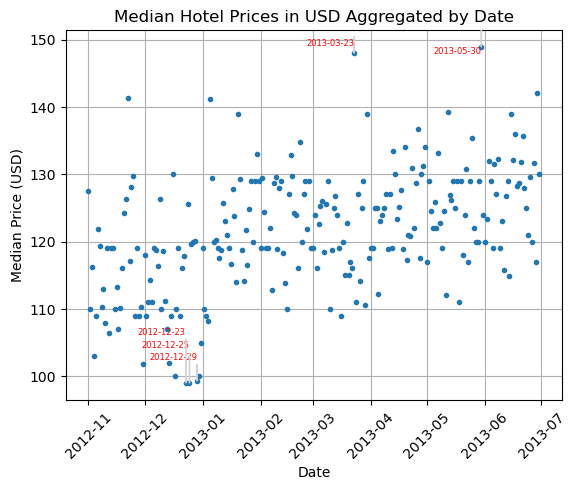

In [6]:
# Want to label outliers
IQR = price_trends_df["price_usd"].quantile(0.75) - price_trends_df["price_usd"].quantile(0.25)
upper = price_trends_df["price_usd"].quantile(0.75) + 1.5 * IQR
lower = price_trends_df["price_usd"].quantile(0.25) - 1.5 * IQR
outliers = price_trends_df[((price_trends_df["price_usd"] < lower) | (price_trends_df["price_usd"] > upper))]
outliers = outliers.sort_values(by = "date", ascending=False)

plt.plot(price_trends_df["date"], price_trends_df["price_usd"], '.')
plt.xlabel("Date")
plt.ylabel("Median Price (USD)")
plt.title("Median Hotel Prices in USD Aggregated by Date")
plt.xticks(rotation=45)

for i in range(outliers.shape[0]):
    plt.annotate(f"{outliers.iloc[i,0]}", 
                 (outliers.iloc[i,0], outliers.iloc[i,1]), 
                 textcoords="offset points", xytext=(0,10 * i - 5), 
                 ha='right', fontsize=6, color='red',
                 arrowprops=dict(width = 0.05, headwidth = 0.2, color='lightgrey'))

plt.grid()
plt.show()

## Vacation Peaks and Date Analysis

In [7]:
stay_length_freq = cust_origin_df.groupby(['date', 'srch_length_of_stay'])['srch_id'].nunique()
stay_length_freq = stay_length_freq.reset_index()
stay_length_freq = stay_length_freq.rename(columns={'srch_id': 'NumSearches'})

In [8]:
mean_stay_length = stay_length_freq.groupby('date').apply(
    lambda x: (x['srch_length_of_stay'] * x['NumSearches']).sum() / x['NumSearches'].sum()
).reset_index(name='mean_stay_length')
mean_stay_length.sort_values(by='mean_stay_length', ascending=False).head()

,date,mean_stay_length
176,2013-04-26,3.296296
205,2013-05-25,3.270833
65,2013-01-05,3.268293
80,2013-01-20,3.261905
37,2012-12-08,3.136364


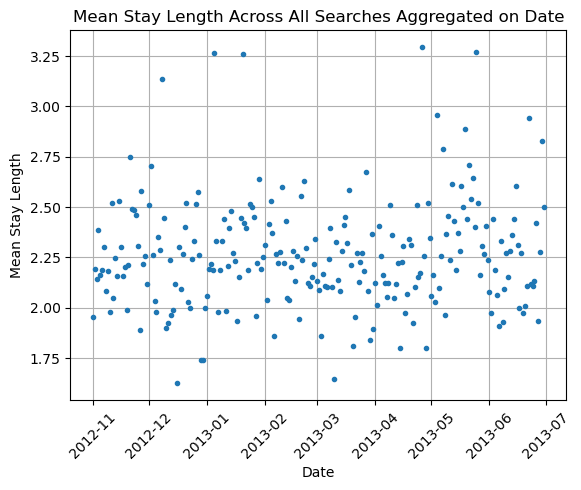

In [9]:
plt.plot(mean_stay_length['date'], mean_stay_length['mean_stay_length'], ".")
plt.xlabel("Date")
plt.ylabel("Mean Stay Length")
plt.title("Mean Stay Length Across All Searches Aggregated on Date")
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [10]:
"""
import matplotlib.cm as cm
norm = plt.Normalize(vmin=stay_length_freq['NumSearches'].min(), vmax=stay_length_freq['NumSearches'].max())
cmap = cm.viridis 
plt.scatter(stay_length_freq["date"], 
            stay_length_freq["srch_length_of_stay"], 
            s = stay_length_freq["NumSearches"],
            c=stay_length_freq['NumSearches'],
            cmap=cmap,
            alpha=0.6)

plt.xlabel("Date")
plt.ylabel("Stay Length")
plt.title("Length of Stay by Date")
plt.xticks(rotation=45)
plt.grid()
plt.show()"""

'\nimport matplotlib.cm as cm\nnorm = plt.Normalize(vmin=stay_length_freq[\'NumSearches\'].min(), vmax=stay_length_freq[\'NumSearches\'].max())\ncmap = cm.viridis \nplt.scatter(stay_length_freq["date"], \n            stay_length_freq["srch_length_of_stay"], \n            s = stay_length_freq["NumSearches"],\n            c=stay_length_freq[\'NumSearches\'],\n            cmap=cmap,\n            alpha=0.6)\n\nplt.xlabel("Date")\nplt.ylabel("Stay Length")\nplt.title("Length of Stay by Date")\nplt.xticks(rotation=45)\nplt.grid()\nplt.show()'

## Location & Review on Hotel Price Analysis

In [11]:
location_price_trends = cust_origin_df.groupby("prop_country_id")["price_usd"].median().sort_values()

top_10_highest_price = location_price_trends.sort_values(ascending=False).head(10)
top_10_highest_price

# https://developers.expediagroup.com/docs/products/rapid/lodging/geography/geography-reference-lists#countries
# Top 5 are mostly African countries with two that are not very popular
# 63 is Gambia, 156 is Sao Tome and Principe, 187 is Uganda, 113 is Martinique

prop_country_id
63     451.83
34     413.69
156    395.00
187    387.41
113    378.50
20     355.61
173    253.79
90     252.50
136    251.80
159    250.00
Name: price_usd, dtype: float64

In [44]:
# Is it expensive because there are less options?
amt_hotels_by_loc = cust_origin_df.groupby("prop_country_id")["prop_id"].nunique()

amt_hotels_by_loc = amt_hotels_by_loc.sort_values(ascending=False)
amt_hotels_by_loc = amt_hotels_by_loc.reset_index()
amt_hotels_by_loc = amt_hotels_by_loc.rename(columns = {"prop_id":"NumUniqueHotelIDs"})

In [45]:
amt_hotels_by_loc["NumUniqueHotelIDs"].describe()

count      156.000000
mean       556.634615
std       2714.065224
min          2.000000
25%         19.750000
50%         56.500000
75%        261.000000
max      32340.000000
Name: NumUniqueHotelIDs, dtype: float64

In [13]:
review_price_trends = cust_origin_df.groupby("prop_review_score")["price_usd"].median().sort_values()

top_10_highest_price = review_price_trends.sort_values(ascending=False).head(10)
top_10_highest_price


prop_review_score
5.0    162.990
4.5    159.000
4.0    123.080
0.0    103.300
3.5     95.000
3.0     77.115
1.0     69.000
2.0     69.000
2.5     69.000
1.5     62.000
Name: price_usd, dtype: float64

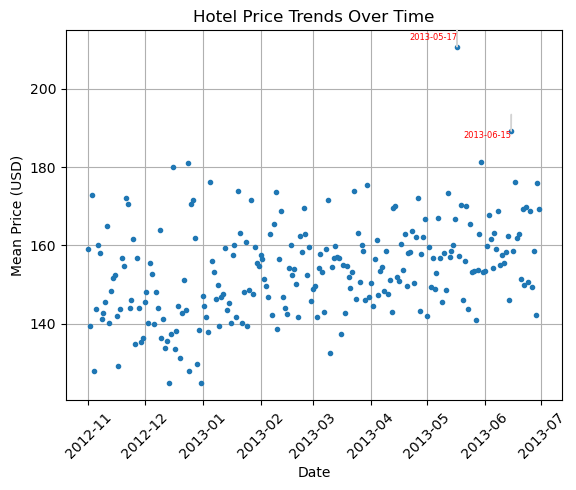

In [14]:
price_trends_mean = cust_origin_df.groupby(cust_origin_df["date_time"].dt.date)["price_usd"].mean()
price_trends_mean_df = price_trends_mean.reset_index()
price_trends_mean_df = pd.DataFrame(price_trends_mean_df)
price_trends_mean_df.columns

# Want to label outliers
IQR = price_trends_mean_df["price_usd"].quantile(0.75) - price_trends_mean_df["price_usd"].quantile(0.25)
upper = price_trends_mean_df["price_usd"].quantile(0.75) + 1.5 * IQR
lower = price_trends_mean_df["price_usd"].quantile(0.25) - 1.5 * IQR
outliers_mean = price_trends_mean_df[((price_trends_mean_df["price_usd"] < lower) | (price_trends_mean_df["price_usd"] > upper))]
outliers_mean = outliers_mean.sort_values(by = "date_time", ascending=False)

plt.plot(price_trends_mean_df["date_time"], price_trends_mean_df["price_usd"], '.')
plt.xlabel("Date")
plt.ylabel("Mean Price (USD)")
plt.title("Hotel Price Trends Over Time")
plt.xticks(rotation=45)

for i in range(outliers_mean.shape[0]):
    plt.annotate(f"{outliers_mean.iloc[i,0]}", 
                 (outliers_mean.iloc[i,0], outliers_mean.iloc[i,1]), 
                 textcoords="offset points", xytext=(0,10 * i - 5), 
                 ha='right', fontsize=6, color='red',
                 arrowprops=dict(width = 0.05, headwidth = 0.2, color='lightgrey'))

plt.grid()
plt.show()

In [22]:
usa_hotels = cust_origin_df[(cust_origin_df["prop_country_id"] == 201)]
usa_hotels.shape
# only 63 rows for USA hotels


(63, 10)

(array([15868.  , 15868.25, 15868.5 , 15868.75, 15869.  , 15869.25,
        15869.5 , 15869.75, 15870.  ]),
 [Text(15868.0, 0, '06-12 00'),
  Text(15868.25, 0, '06-12 06'),
  Text(15868.5, 0, '06-12 12'),
  Text(15868.75, 0, '06-12 18'),
  Text(15869.0, 0, '06-13 00'),
  Text(15869.25, 0, '06-13 06'),
  Text(15869.5, 0, '06-13 12'),
  Text(15869.75, 0, '06-13 18'),
  Text(15870.0, 0, '06-14 00')])

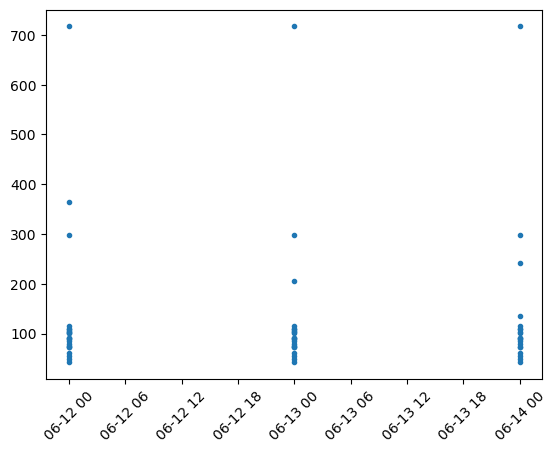

In [24]:
plt.plot(usa_hotels["date"], usa_hotels["price_usd"], ".")
plt.xticks(rotation = 45)

In [26]:
usa_hotels["date"].unique()

array([datetime.date(2013, 6, 14), datetime.date(2013, 6, 13),
       datetime.date(2013, 6, 12)], dtype=object)

In [34]:
cust_origin_df["prop_country_id"].value_counts().head(20)

prop_country_id
219    260015
55      27961
100     25644
31      23235
99      17048
129     13190
215     10197
220      9685
216      7718
117      7223
98       6971
59       5575
132      5386
158      4961
205      4094
39       4039
32       3985
15       3843
103      3293
92       3269
Name: count, dtype: int64

In [35]:
cust_origin_df["visitor_location_country_id"].value_counts().head(20)

visitor_location_country_id
219    235962
55      46380
100     40426
216     31240
220     27373
31      26003
129     10264
103      9401
99       7410
59       6835
158      6833
132      5065
117      4208
39       2858
215      2403
81       2186
92       2037
23       1785
138      1783
98       1713
Name: count, dtype: int64

Text(0, 0.5, 'Times Appeared in Search')

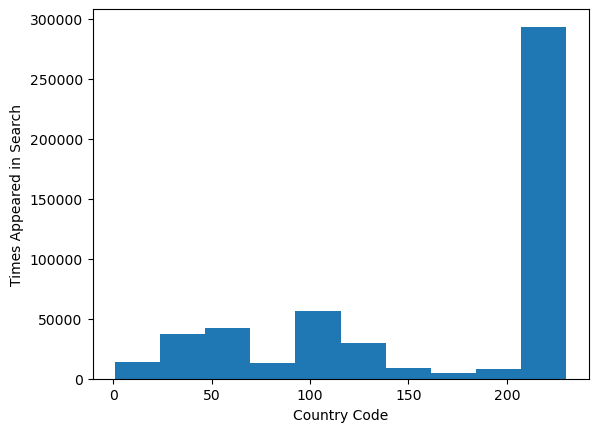

In [30]:
plt.hist(cust_origin_df["prop_country_id"])
plt.xlabel("Country Code")
plt.ylabel("Times Appeared in Search")

Text(0, 0.5, 'Times Appeared in Search')

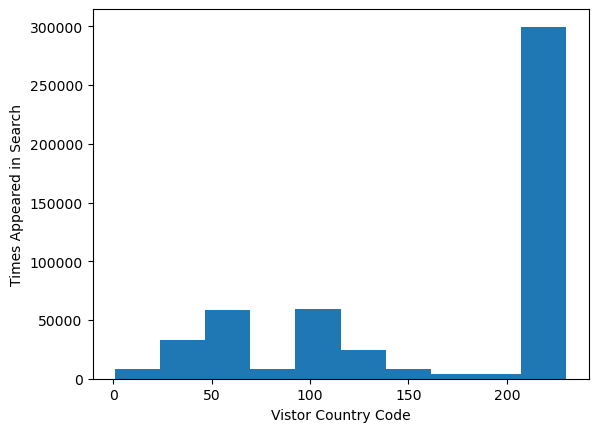

In [31]:
plt.hist(cust_origin_df["visitor_location_country_id"])
plt.xlabel("Vistor Country Code")
plt.ylabel("Times Appeared in Search")